### MNLI task is to classify relationships between pairs of sentences as contradication, entailment or neutral.

### Importing the required libraries

In [ ]:
import pickle
import torch
import numpy as np
import pandas as pd
from datasets import load_dataset
from torch.utils.data import TensorDataset, random_split
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt

### Checking if gpu is available

In [1]:
import torch

if torch.cuda.is_available():       
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: NVIDIA RTX A4000


### Loading the dataset

In [2]:
from datasets import load_dataset
dataset = load_dataset('glue', 'mnli')
dataset

Found cached dataset glue (C:/Users/NIT/.cache/huggingface/datasets/glue/mnli/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad)


  0%|          | 0/5 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 392702
    })
    validation_matched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 9815
    })
    validation_mismatched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 9832
    })
    test_matched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 9796
    })
    test_mismatched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 9847
    })
})

### Using the tokenizer from huggingface

In [4]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("gchhablani/bert-base-cased-finetuned-mnli")

### Loading the pre-trained and fine-tuned models from huggingface and moving them to device

In [7]:
preTrainedModel = AutoModelForSequenceClassification.from_pretrained("bert-base-cased",
                                                      num_labels = 3,
                                                      output_attentions = True,
                                                      output_hidden_states = True,)
preTrainedModel.cuda()

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at b

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [6]:
from transformers import AutoModelForSequenceClassification
fineTunedModel = AutoModelForSequenceClassification.from_pretrained("gchhablani/bert-base-cased-finetuned-mnli")
fineTunedModel.cuda()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [ ]:
train_premise = dataset['train']['premise']
train_hypothesis = dataset['train']['hypothesis']

In [8]:
def getCLSHiddenStates(model, prediction_dataloader):
    model.eval()
    totalHiddenStates = [0]*13
    flag = True
    for batch in prediction_dataloader:
        batch = tuple(t.to(device) for t in batch)
  
        # Unpack the inputs from our dataloader
        b_input_ids, b_token_type_ids, b_input_mask, b_labels = batch
  
        with torch.no_grad():
            result = model(b_input_ids,
                           token_type_ids=b_token_type_ids,
                           attention_mask=b_input_mask,
                           output_hidden_states = True,
                           return_dict=True)
            
        hidden_states = result.hidden_states
        if flag == True:
            for i in range(len(hidden_states)):
                totalHiddenStates[i] = hidden_states[i][:,0,:].to("cpu")
            flag = False
        else:
            for i in range(len(hidden_states)):
                temp = hidden_states[i][:,0,:].to("cpu")
                totalHiddenStates[i] = torch.cat((totalHiddenStates[i], temp), 0)
    return totalHiddenStates     

In [ ]:
num_rows = dataset['train'].num_rows
hiddenStates = [0]*13
flag = True
for i in range(0, num_rows//10000 +1):
    print(i)
    st = i*10000
    if(i==num_rows//10000):
        end = num_rows
    else:
        end = (i+1)*10000
    tokenised_dataset = tokenizer(train_premise[st:end], 
                                  train_hypothesis[st:end], truncation = True, padding=True, return_tensors='pt')
    input_ids = tokenised_dataset['input_ids']
    token_type_ids = tokenised_dataset['token_type_ids']
    attention_masks = tokenised_dataset['attention_mask']
    labels = torch.tensor(dataset['train']['label'][st:end])
  
    
    batch_size = 16 
    train_data = TensorDataset(input_ids, token_type_ids, attention_masks, labels)
    train_sampler = SequentialSampler(train_data)
    train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)
    
    hS = getCLSHiddenStates(preTrainedModel, train_dataloader)
    if flag==True:
        for j in range(13):
            hiddenStates[j] = hS[j]
        flag = False
    else:
        for j in range(13):
            hiddenStates[j] = torch.cat((hiddenStates[j], hS[j]), dim = 0)

preTrainedCLSHiddenStatesTrain = torch.stack(hiddenStates, dim = 0)
#torch.save(preTrainedCLSHiddenStatesTrain, 'preTrainedCLSHiddenStatesTrain_mnli.pt')
preTrainedCLSHiddenStatesTrain.shape

In [ ]:
num_rows = dataset['train'].num_rows
hiddenStates = [0]*13
flag = True
for i in range(0, num_rows//10000 +1):
    print(i)
    st = i*10000
    if(i==num_rows//10000):
        end = num_rows
    else:
        end = (i+1)*10000
    tokenised_dataset = tokenizer(train_premise[st:end], 
                                  train_hypothesis[st:end], truncation = True, padding=True, return_tensors='pt')
    input_ids = tokenised_dataset['input_ids']
    token_type_ids = tokenised_dataset['token_type_ids']
    attention_masks = tokenised_dataset['attention_mask']
    labels = torch.tensor(dataset['train']['label'][st:end])
  
    
    batch_size = 16 
    train_data = TensorDataset(input_ids, token_type_ids, attention_masks, labels)
    train_sampler = SequentialSampler(train_data)
    train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)
    
    hS = getCLSHiddenStates(fineTunedModel, train_dataloader)
    if flag==True:
        for j in range(13):
            hiddenStates[j] = hS[j]
        flag = False
    else:
        for j in range(13):
            hiddenStates[j] = torch.cat((hiddenStates[j], hS[j]), dim = 0)

fineTunedCLSHiddenStatesTrain = torch.stack(hiddenStates, dim = 0)
#torch.save(preTrainedCLSHiddenStatesTrain, 'preTrainedCLSHiddenStatesTrain_mnli.pt')
fineTunedCLSHiddenStatesTrain.shape

### Forming dataloaders

In [14]:
tokenised_dataset = tokenizer(dataset['test_matched']['premise'], dataset['test_matched']['hypothesis'], truncation = True, padding=True, return_tensors='pt')
input_ids = tokenised_dataset['input_ids']
token_type_ids = tokenised_dataset['token_type_ids']
attention_masks = tokenised_dataset['attention_mask']
labels = torch.tensor(dataset['test_matched']['label'])

# Set the batch size.  
batch_size = 16 

# Create the DataLoader.
test_data1 = TensorDataset(input_ids, token_type_ids, attention_masks, labels)
test_sampler1 = SequentialSampler(test_data1)
test_dataloader1 = DataLoader(test_data1, sampler=test_sampler1, batch_size=batch_size)

In [15]:
tokenised_dataset = tokenizer(dataset['test_mismatched']['premise'], dataset['test_mismatched']['hypothesis'], truncation=True, padding=True, return_tensors='pt')
input_ids = tokenised_dataset['input_ids']
token_type_ids = tokenised_dataset['token_type_ids']
attention_masks = tokenised_dataset['attention_mask']
labels = torch.tensor(dataset['test_mismatched']['label'])

# Set the batch size.  
batch_size = 16 

# Create the DataLoader.
test_data2 = TensorDataset(input_ids, token_type_ids, attention_masks, labels)
test_sampler2 = SequentialSampler(test_data2)
test_dataloader2 = DataLoader(test_data2, sampler=test_sampler2, batch_size=batch_size)

In [16]:
dataset2 = load_dataset('glue', 'ax')
dataset2

Found cached dataset glue (C:/Users/NIT/.cache/huggingface/datasets/glue/ax/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad)


  0%|          | 0/1 [00:00<?, ?it/s]

DatasetDict({
    test: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 1104
    })
})

In [ ]:
testax_premise = dataset2['test']['premise']
testax_hypothesis = dataset2['test']['hypothesis']

In [18]:
tokenised_dataset = tokenizer(testax_premise, testax_hypothesis, truncation = True,  padding=True, return_tensors='pt')
input_ids = tokenised_dataset['input_ids']
token_type_ids = tokenised_dataset['token_type_ids']
attention_masks = tokenised_dataset['attention_mask']
labels = torch.tensor(dataset2['test']['label'])

# Set the batch size.  
batch_size = 16 

# Create the DataLoader.
test_data3 = TensorDataset(input_ids, token_type_ids, attention_masks, labels)
test_sampler3 = SequentialSampler(test_data3)
test_dataloader3 = DataLoader(test_data3, sampler=test_sampler3, batch_size=batch_size)

In [17]:
hiddenStates = getCLSHiddenStates(preTrainedModel, test_dataloader1)
preTrainedCLSHiddenStatesTestm = torch.stack(hiddenStates, dim = 0)
#torch.save(preTrainedCLSHiddenStatesTestm, 'preTrainedCLSHiddenStatesTest_mnli-m.pt')
preTrainedCLSHiddenStatesTestm.shape

torch.Size([9796, 768])

In [18]:
hiddenStates = getCLSHiddenStates(fineTunedModel, test_dataloader1)
fineTunedCLSHiddenStatesTestm = torch.stack(hiddenStates, dim = 0)
#torch.save(fineTunedCLSHiddenStatesTestm, 'fineTunedCLSHiddenStatesTest_mnli-m.pt')
fineTunedCLSHiddenStatesTestm.shape

torch.Size([9796, 768])

In [19]:
hiddenStates = getCLSHiddenStates(preTrainedModel, test_dataloader2)
preTrainedCLSHiddenStatesTestmm = torch.stack(hiddenStates, dim = 0)
#torch.save(preTrainedCLSHiddenStatesTestmm, 'preTrainedCLSHiddenStatesTest_mnli-mm.pt')
preTrainedCLSHiddenStatesTestmm.shape

torch.Size([9847, 768])

In [20]:
hiddenStates = getCLSHiddenStates(fineTunedModel, test_dataloader2)
fineTunedCLSHiddenStatesTestmm = torch.stack(hiddenStates, dim = 0)
#torch.save(fineTunedCLSHiddenStatesTestmm, 'fineTunedCLSHiddenStatesTest_mnli-mm.pt')
fineTunedCLSHiddenStatesTestmm.shape

torch.Size([9847, 768])

In [21]:
hiddenStates = getCLSHiddenStates(preTrainedModel, test_dataloader3)
preTrainedCLSHiddenStatesTestax = torch.stack(hiddenStates, dim = 0)
#torch.save(preTrainedCLSHiddenStatesTestax, 'preTrainedCLSHiddenStatesTest_mnli-ax.pt')
preTrainedCLSHiddenStatesTestax.shape

torch.Size([1104, 768])

In [22]:
hiddenStates = getCLSHiddenStates(fineTunedModel, test_dataloader3)
fineTunedCLSHiddenStatesTestax = torch.stack(hiddenStates, dim = 0)
#torch.save(fineTunedCLSHiddenStatesTestax, 'fineTunedCLSHiddenStatesTest_mnli-ax.pt')
fineTunedCLSHiddenStatesTestax.shape

torch.Size([1104, 768])

In [22]:
def getLabels(model, data_loader):
    predictions = []
    for batch in data_loader:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_token_type_ids, b_input_mask, b_labels = batch
  
        with torch.no_grad():
            results = model(b_input_ids, token_type_ids=b_token_type_ids, attention_mask=b_input_mask, return_dict=True)
            logits = results.logits
            pred = torch.argmax(logits, dim = 1)
            pPred = []
            for j in range(len(pred)):
                if pred[j]==0:
                    pPred.append('entailment')
                elif(pred[j]==1):
                    pPred.append('neutral')
                else:
                    pPred.append('contradiction')
            predictions.extend(pPred)
    return predictions

In [26]:
import numpy as np
import pandas as pd
predictions = getLabels(fineTunedModel, test_dataloader3)
filename = 'AX.tsv'
result = pd.DataFrame(predictions, columns=['prediction'])
result.insert(0, 'index', range(0, len(result)))
result.to_csv(filename, sep='\t', index=False)

### Forming logistic regressions at each layer to find the layer-wise accuracy for pre-trained and fine-tuned model

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
sc_x = StandardScaler()
for i in range(13):
    xtrain = sc_x.fit_transform(preTrainedCLSHiddenStatesTrain[i])
    logreg = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000)
    logreg.fit(xtrain, dataset['train']['label'])
    
    xtest = sc_x.fit_transform(preTrainedCLSHiddenStatesTestm[i])
    preTrain_pred=logreg.predict(xtest)
    pPred = []
    for j in range(len(preTrain_pred)):
        if preTrain_pred[j]==0:
            pPred.append('entailment')
        elif(preTrain_pred[j]==1):
            pPred.append('neutral')
        else:
            pPred.append('contradiction')

    filename = 'p{0}/MNLI-m.tsv'.format(i)
    result = pd.DataFrame(pPred, columns=['prediction'])
    result.insert(0, 'index', range(0, len(result)))
    result.to_csv(filename, sep='\t', index=False)
    

    
    xtest = sc_x.fit_transform(preTrainedCLSHiddenStatesTestmm[i])
    preTrain_pred=logreg.predict(xtest)
    pPred = []
    for j in range(len(preTrain_pred)):
        if preTrain_pred[j]==0:
            pPred.append('entailment')
        elif(preTrain_pred[j]==1):
            pPred.append('neutral')
        else:
            pPred.append('contradiction')
    filename = 'p{0}/MNLI-mm.tsv'.format(i)
    result = pd.DataFrame(pPred, columns=['prediction'])
    result.insert(0, 'index', range(0, len(result)))
    result.to_csv(filename, sep='\t', index=False)
    
    
    xtest = sc_x.fit_transform(preTrainedCLSHiddenStatesTestax[i])
    preTrain_pred=logreg.predict(xtest)
    pPred = []
    for j in range(len(preTrain_pred)):
        if preTrain_pred[j]==0:
            pPred.append('entailment')
        elif(preTrain_pred[j]==1):
            pPred.append('neutral')
        else:
            pPred.append('contradiction')
    filename = 'p{0}/AX.tsv'.format(i)
    result = pd.DataFrame(pPred, columns=['prediction'])
    result.insert(0, 'index', range(0, len(result)))
    result.to_csv(filename, sep='\t', index=False)

In [ ]:
for i in range(13):    
    xtrain = sc_x.fit_transform(fineTunedCLSHiddenStatesTrain[i]) 
    logreg = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000)
    logreg.fit(xtrain, dataset['train']['label'])
    
    xtest = sc_x.fit_transform(fineTunedCLSHiddenStatesTestm[i])
    fineTune_pred=logreg.predict(xtest)
    fPred = []
    for j in range(len(fineTune_pred)):
        if fineTune_pred[j]==0:
            fPred.append('entailment')
        elif(fineTune_pred[j]==1):
            fPred.append('neutral')
        else:
            fPred.append('contradiction')
    filename = 'f{0}/MNLI-m.tsv'.format(i)
    result = pd.DataFrame(fPred, columns=['prediction'])
    result.insert(0, 'index', range(0, len(result)))
    result.to_csv(filename, sep='\t', index=False)
    
    
    xtest = sc_x.fit_transform(fineTunedCLSHiddenStatesTestmm[i])
    fineTune_pred=logreg.predict(xtest)
    fPred = []
    for j in range(len(fineTune_pred)):
        if fineTune_pred[j]==0:
            fPred.append('entailment')
        elif(fineTune_pred[j]==1):
            fPred.append('neutral')
        else:
            fPred.append('contradiction')
    filename = 'f{0}/MNLI-mm.tsv'.format(i)
    result = pd.DataFrame(fPred, columns=['prediction'])
    result.insert(0, 'index', range(0, len(result)))
    result.to_csv(filename, sep='\t', index=False)
    
    
    xtest = sc_x.fit_transform(fineTunedCLSHiddenStatesTestax[i])
    fineTune_pred=logreg.predict(xtest)
    fPred = []
    for j in range(len(fineTune_pred)):
        if fineTune_pred[j]==0:
            fPred.append('entailment')
        elif(fineTune_pred[j]==1):
            fPred.append('neutral')
        else:
            fPred.append('contradiction')
    filename = 'f{0}/AX.tsv'.format(i)
    result = pd.DataFrame(fPred, columns=['prediction'])
    result.insert(0, 'index', range(0, len(result)))
    result.to_csv(filename, sep='\t', index=False)

### Finding the accuracy of the final layer using the classifier of the fine-tuned model

In [ ]:
params = list(fineTunedModel.named_parameters())
dense = torch.nn.Linear(768, 768,device=device, bias = True)
activation = torch.nn.Tanh()
dropout = torch.nn.Dropout(p=0.1)
classifier = torch.nn.Linear(in_features=768, out_features=3,  bias = True)
with torch.no_grad():
    dense.weight = params[-4][1]
    dense.bias = params[-3][1]
    classifier.weight = params[-2][1]
    classifier.bias = params[-1][1]

In [ ]:
pooled_output = activation(dense(fineTunedCLSHiddenStatesTestm[-1].to('cuda:0')))
dropout_op = dropout(pooled_output)
logits = classifier(dropout_op)
predictions = torch.argmax(logits, dim = 1)

In [ ]:
import pandas as pd
predictions = predictions.to('cpu')
Pred = []
for j in range(len(predictions)):
    if predictions[j]==0:
        Pred.append('entailment')
    elif(predictions[j]==1):
        Pred.append('neutral')
    else:
        Pred.append('contradiction')

filename = 'MNLI-m.tsv'
result = pd.DataFrame(Pred, columns=['prediction'])
result.insert(0, 'index', range(0, len(result)))
result.to_csv(filename, sep='\t', index=False)

In [ ]:
import pandas as pd
predictions = predictions.to('cpu')
Pred = []
for j in range(len(predictions)):
    if predictions[j]==0:
        Pred.append('entailment')
    elif(predictions[j]==1):
        Pred.append('neutral')
    else:
        Pred.append('contradiction')

filename = 'passiveAX.tsv'
result = pd.DataFrame(Pred, columns=['prediction'])
result.insert(0, 'index', range(0, len(result)))
result.to_csv(filename, sep='\t', index=False)

### Obtaining hidden states to find the CKA metric between the pre-trained and fine-tuned model on test dataset

In [ ]:
def getHiddenStates(model, prediction_dataloader):
    model.eval()
    totalHiddenStates = [0]*13
    flag = True
    for batch in prediction_dataloader:
        # Add batch to GPU
        batch = tuple(t.to(device) for t in batch)
  
        # Unpack the inputs from our dataloader
        b_input_ids, b_token_type_ids, b_input_mask, b_labels = batch
  
        with torch.no_grad():
            result = model(b_input_ids,
                           token_type_ids=b_token_type_ids,
                           attention_mask=b_input_mask,
                           output_hidden_states = True,
                           return_dict=True)
            
        hidden_states = result.hidden_states
        if flag == True:
            for i in range(len(hidden_states)):
                totalHiddenStates[i] = hidden_states[i].to("cpu").mean(dim = 1)
            flag = False
        else:
            for i in range(len(hidden_states)):
                temp = hidden_states[i].to("cpu").mean(dim = 1)
                totalHiddenStates[i] = torch.cat((totalHiddenStates[i], temp), 0)   
    return totalHiddenStates     

In [ ]:
hiddenStates = getHiddenStates(preTrainedModel, test_dataloader1)
preTrainedHiddenStates_m = torch.stack(hiddenStates, dim = 0)
#torch.save(preTrainedHiddenStates_m, 'preTrainedHiddenStates_mnli-m.pt')
preTrainedHiddenStates_m.shape

In [ ]:
hiddenStates = getHiddenStates(fineTunedModel, test_dataloader1)
fineTunedHiddenStates_m = torch.stack(hiddenStates, dim = 0)
#torch.save(fineTunedHiddenStates_m, 'fineTunedHiddenStates_mnli-m.pt')
fineTunedHiddenStates_m.shape

In [ ]:
hiddenStates = getHiddenStates(preTrainedModel, test_dataloader2)
preTrainedHiddenStates_mm = torch.stack(hiddenStates, dim = 0)
#torch.save(preTrainedHiddenStates_mm, 'preTrainedHiddenStates_mnli-mm.pt')
preTrainedHiddenStates_mm.shape

In [ ]:
hiddenStates = getHiddenStates(fineTunedModel, test_dataloader2)
fineTunedHiddenStates_mm = torch.stack(hiddenStates, dim = 0)
#torch.save(fineTunedHiddenStates_mm, 'fineTunedHiddenStates_mnli-mm.pt')
fineTunedHiddenStates_mm.shape

In [ ]:
hiddenStates = getHiddenStates(preTrainedModel, test_dataloader3)
preTrainedHiddenStates_ax = torch.stack(hiddenStates, dim = 0)
#torch.save(preTrainedHiddenStates_ax, 'preTrainedHiddenStates_mnli-ax.pt')
preTrainedHiddenStates_ax.shape

In [ ]:
hiddenStates = getHiddenStates(fineTunedModel, test_dataloader3)
fineTunedHiddenStates_ax = torch.stack(hiddenStates, dim = 0)
#torch.save(fineTunedHiddenStates_ax, 'fineTunedHiddenStates_mnli-ax.pt')
fineTunedHiddenStates_ax.shape

In [ ]:
from CKA import CKA, CudaCKA
cuda_cka = CudaCKA(device)

In [ ]:
cka_matrix = torch.empty((13, 13))
for i in range(13):
    for j in range(13):
        X = preTrainedHiddenStates_m[i].to(device)
        Y = fineTunedHiddenStates_m[j].to(device)
        cka_matrix[i][j] = cuda_cka.linear_CKA(X, Y)
#torch.save(cka_matrix, 'ckaMatrix.pt')
cka_matrix = cka_matrix.numpy()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(figsize=(10, 8))
im = ax.imshow(cka_matrix, cmap="inferno", vmin=0.0, vmax=1.0)

plt.xticks(np.arange(0,13), fontsize = 14)
plt.yticks(np.arange(0,13), fontsize = 14)

cka_matrix = np.round(cka_matrix, 2)
for x in range(13):
    for y in range(13):
        plt.annotate(str(cka_matrix[x][y]), xy=(y, x), horizontalalignment='center', verticalalignment='center', fontsize=13)

plt.ylabel('Pre-trained BERT', fontsize = 17)
plt.xlabel('Fine-tuned BERT', fontsize = 17)

#fig.colorbar(im)

plt.tight_layout()

#plt.show()

plt.savefig('MultiNLI-Matched_preTrained_fineTuned.pdf',  bbox_inches='tight')
plt.savefig('MultiNLI-Matched_preTrained_fineTuned.jpg',  bbox_inches='tight')

In [ ]:
cka_matrix = torch.empty((13, 13))
for i in range(13):
    for j in range(13):
        X = preTrainedHiddenStates_mm[i].to(device)
        Y = fineTunedHiddenStates_mm[j].to(device)
        cka_matrix[i][j] = cuda_cka.linear_CKA(X, Y)
#torch.save(cka_matrix, 'ckaMatrix.pt')
cka_matrix = cka_matrix.numpy()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(figsize=(10, 8))
im = ax.imshow(cka_matrix, cmap="inferno", vmin=0.0, vmax=1.0)

plt.xticks(np.arange(0,13), fontsize = 14)
plt.yticks(np.arange(0,13), fontsize = 14)

cka_matrix = np.round(cka_matrix, 2)
for x in range(13):
    for y in range(13):
        plt.annotate(str(cka_matrix[x][y]), xy=(y, x), horizontalalignment='center', verticalalignment='center', fontsize=13)

plt.ylabel('Pre-trained BERT', fontsize = 17)
plt.xlabel('Fine-tuned BERT', fontsize = 17)

#fig.colorbar(im)

plt.tight_layout()

#plt.show()

plt.savefig('MultiNLI-Mis-Matched_preTrained_fineTuned.pdf',  bbox_inches='tight')
plt.savefig('MultiNLI-Mis-Matched_preTrained_fineTuned.jpg',  bbox_inches='tight')

In [ ]:
cka_matrix = torch.empty((13, 13))
for i in range(13):
    for j in range(13):
        X = preTrainedHiddenStates_ax[i].to(device)
        Y = fineTunedHiddenStates_ax[j].to(device)
        cka_matrix[i][j] = cuda_cka.linear_CKA(X, Y)
#torch.save(cka_matrix, 'ckaMatrix.pt')
cka_matrix = cka_matrix.numpy()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(figsize=(10, 8))
im = ax.imshow(cka_matrix, cmap="inferno", vmin=0.0, vmax=1.0)

plt.xticks(np.arange(0,13), fontsize = 14)
plt.yticks(np.arange(0,13), fontsize = 14)

cka_matrix = np.round(cka_matrix, 2)
for x in range(13):
    for y in range(13):
        plt.annotate(str(cka_matrix[x][y]), xy=(y, x), horizontalalignment='center', verticalalignment='center', fontsize=13)

plt.ylabel('Pre-trained BERT', fontsize = 17)
plt.xlabel('Fine-tuned BERT', fontsize = 17)

#fig.colorbar(im)

plt.tight_layout()

#plt.show()

plt.savefig('AX_preTrained_fineTuned.pdf',  bbox_inches='tight')
plt.savefig('AX_preTrained_fineTuned.jpg',  bbox_inches='tight')

### STIR

In [19]:
preTrainedHiddenStates = torch.load('./preTrainedHiddenStates_mnli-ax.pt').to(device)
fineTunedHiddenStates  = torch.load('./fineTunedHiddenStates_mnli-ax.pt').to(device)

In [20]:
print(preTrainedHiddenStates.shape,fineTunedHiddenStates.shape)

torch.Size([13, 1104, 768]) torch.Size([13, 1104, 768])


In [21]:
distinm1 = []
distinm2 = []
for i in range(13):
    distinm1.append(torch.cdist(preTrainedHiddenStates[i], preTrainedHiddenStates[i]))
    distinm2.append(torch.cdist(fineTunedHiddenStates[i], fineTunedHiddenStates[i]))

In [22]:
for i in range(13):
    for j in range(distinm1[0].shape[0]):
        distinm1[i][j][j] = 100000.0
        distinm2[i][j][j] = 100000.0

In [23]:
num_rows = preTrainedHiddenStates.shape[1]
minDistIndForm1 = []
for i in range(13):
    temp = []
    for j in range(num_rows):
        temp.append(torch.argmin(distinm1[i][j]))
    minDistIndForm1.append(temp)
    
minDistIndForm2 = []
for i in range(13):
    temp = []
    for j in range(num_rows):
        temp.append(torch.argmin(distinm2[i][j]))
    minDistIndForm2.append(temp)

In [24]:
from CKA import CKA, CudaCKA
cuda_cka = CudaCKA(device)

In [25]:
import random
def calculate(noOfSamples, noOfTimes):
    STIRm2m1 = []
    STIRm1m2 = []
    CKA = []
    for i in range(13):
        stirm2m1 = 0
        stirm1m2 = 0
        cka = 0
        for j in range(noOfTimes):
            num_list = random.sample(range(0, num_rows), noOfSamples)
            X = []
            X_ = []
            Y = []
            Y_ = []
            for k in range(len(num_list)):
                X.append(fineTunedHiddenStates[i][num_list[k]])
                X_.append(fineTunedHiddenStates[i][minDistIndForm1[i][num_list[k]]])
                Y.append(preTrainedHiddenStates[i][num_list[k]])
                Y_.append(preTrainedHiddenStates[i][minDistIndForm2[i][num_list[k]]])
                
            X = torch.stack(X, dim = 0)
            X_ = torch.stack(X_, dim = 0)
            Y = torch.stack(Y, dim = 0)
            Y_ = torch.stack(Y_, dim = 0)
            
            stirm2m1 = stirm2m1 + cuda_cka.linear_CKA(X, X_)
            stirm1m2 = stirm1m2 + cuda_cka.linear_CKA(Y, Y_)
            cka = cka + cuda_cka.linear_CKA(Y, X)
        
        STIRm2m1.append(stirm2m1/noOfTimes)
        STIRm1m2.append(stirm1m2/noOfTimes)
        CKA.append(cka/noOfTimes)
    return STIRm2m1, STIRm1m2, CKA

In [26]:
STIRm2m1, STIRm1m2, CKA = calculate(num_rows//2, 20)

In [27]:
STIRm2m1 = torch.stack(STIRm2m1, dim = 0)
STIRm1m2 = torch.stack(STIRm1m2,dim = 0)
CKA = torch.stack(CKA, dim = 0)

In [28]:
STIRm2m1 = STIRm2m1.to("cpu")
STIRm2m1 = STIRm2m1.numpy()
STIRm1m2 = STIRm1m2.to("cpu")
STIRm1m2 = STIRm1m2.numpy()
CKA = CKA .to("cpu")
CKA = CKA .numpy()

In [33]:
print('MultiNLI Matched: ')
print('STIRm2m1:', STIRm2m1)
print('STIRm1m2:', STIRm1m2)
print('CKA:', CKA)

MultiNLI Matched: 
STIRm2m1: [0.98041785 0.9792513  0.95152473 0.9429107  0.95042974 0.9302541
 0.900427   0.8464845  0.8260652  0.8047795  0.740901   0.60085076
 0.09877233]
STIRm1m2: [0.9802734  0.98260164 0.95885843 0.95170516 0.9561742  0.9560696
 0.9557374  0.953673   0.95236903 0.9454916  0.9296031  0.88883364
 0.5621771 ]
CKA: [0.9999943  0.9744178  0.9329721  0.94144803 0.933718   0.91172045
 0.8779851  0.83821833 0.8104092  0.77089    0.68687505 0.56582785
 0.06700876]


In [17]:
print('MultiNLI Mis-Matched: ')
print('STIRm2m1:', STIRm2m1)
print('STIRm1m2:', STIRm1m2)
print('CKA:', CKA)

MultiNLI Mis-Matched: 
STIRm2m1: [0.9792304  0.9756118  0.94952804 0.9365913  0.94396    0.92171043
 0.88090354 0.8125022  0.793868   0.7732425  0.71282995 0.5576588
 0.09430637]
STIRm1m2: [0.9790072  0.97980636 0.95791525 0.9494359  0.9507338  0.9489395
 0.94679844 0.94559205 0.94545835 0.93818754 0.9205944  0.869924
 0.53024954]
CKA: [0.9999943  0.97138053 0.93726057 0.94368076 0.93860906 0.92115444
 0.8821905  0.82639456 0.80338526 0.76416296 0.6835911  0.5600915
 0.07605956]


In [29]:
print('AX: ')
print('STIRm2m1:', STIRm2m1)
print('STIRm1m2:', STIRm1m2)
print('CKA:', CKA)

AX: 
STIRm2m1: [0.9992385  0.9976229  0.9971987  0.99713105 0.9955953  0.9942026
 0.98739034 0.9796667  0.9740187  0.9720046  0.9635213  0.9179037
 0.44487333]
STIRm1m2: [0.9992404  0.9975626  0.99690306 0.9971735  0.99577045 0.9949276
 0.992567   0.9909205  0.98961955 0.98875344 0.9872759  0.98308176
 0.87677824]
CKA: [0.9999942  0.99582845 0.98032427 0.98080206 0.97052    0.9222913
 0.8808608  0.8406852  0.8208451  0.8040043  0.7921142  0.71190184
 0.22462793]


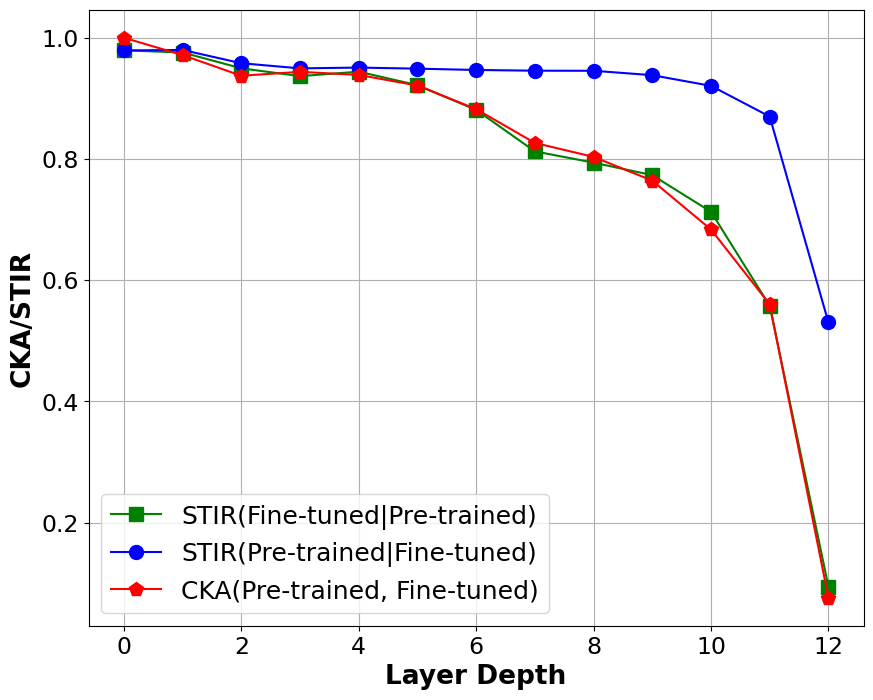

In [6]:
import numpy as np
import matplotlib.pyplot as plt

xs = np.arange(13)
plt.rcParams["figure.figsize"] = [10,8]

series = np.array(STIRm2m1)
smask = np.isfinite(series)
plt.plot(xs[smask], series[smask], linestyle='-', marker='s', markersize=10, color='green')

series = np.array(STIRm1m2)
smask = np.isfinite(series)
plt.plot(xs[smask], series[smask], linestyle='-', marker='o', markersize=10, color='blue')

series = np.array(CKA)
smask = np.isfinite(series)
plt.plot(xs[smask], series[smask], linestyle='-', marker='p', markersize=10, color='red')

plt.legend(['STIR(Fine-tuned|Pre-trained)', 'STIR(Pre-trained|Fine-tuned)', 'CKA(Pre-trained, Fine-tuned)'], fontsize=18)
plt.xlabel('Layer Depth', fontsize = 19, fontweight = 'bold')
plt.ylabel('CKA/STIR', fontsize = 19, fontweight ='bold')

plt.grid(True)
plt.xticks(fontsize=17)
plt.yticks(fontsize=17)
#plt.tight_layout()
#plt.show()
plt.savefig('AX STIR.pdf', bbox_inches='tight')
plt.savefig('AX STIR.jpg', bbox_inches='tight')